In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# parameters ===============
history_steps = 10
target_as_feature = False
feature_files = ['BWX', 'IEI','LQD','VEA', 'VEU', 'VGK','VPL','VT','VWO'] 
target_file = ['VTI']
train_test_split = 0.7
# program ==================

##Read Files##

for n,m in enumerate(target_file+feature_files):
    df_temp=pd.read_csv(m+'.csv',sep=',',thousands = ',', header = 0, index_col = 0)
    df_temp=df_temp.drop(['Change %', 'Vol.', 'Open','High','Low'], axis=1)
    df_temp.index=pd.to_datetime(df_temp.index)
    df_temp.columns=['Price_'+m]
    if n==0:
        df=df_temp
    else:
        df=df.join(df_temp)
        
##Check and Interpolate Missing Value##
        
missing=pd.isna(df).sum()
df = df.interpolate(method='linear')

##Build Training/Test Dataset##

def timeseries_to_array(df, history_steps, target_as_feature):
    for n in range(df.shape[0]-history_steps):  
        if target_as_feature:
            step_features = df.iloc[n:n+history_steps,:].values.flatten().reshape((1,-1))
        else:
            step_features = df.iloc[n:n+history_steps,1:].values.flatten().reshape((1,-1))
        step_target = df.iloc[n+history_steps, 0]
        if n == 0:
            feature_array = step_features
            target_array = [step_target]
        else:
            feature_array = np.concatenate((feature_array, step_features), axis = 0)
            target_array.append(step_target)

    return feature_array, np.array(target_array)
    
    
x_train, y_train = timeseries_to_array(df.iloc[:int(len(df)*train_test_split),:], 
                               history_steps, target_as_feature)
x_test, y_test = timeseries_to_array(df.iloc[int(len(df)*train_test_split):,:], 
                                 history_steps, target_as_feature)


##Fit Model##
model = RandomForestRegressor(n_estimators = 100, max_depth = 10, 
                              max_features = 0.3, oob_score = True, verbose = 0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('oob_score', model.oob_score_)
FIP=model.feature_importances_
final=pd.DataFrame(FIP)

##Calculate Feature Importance##
if target_as_feature:
    n_index=len(feature_files+target_file)
else:
    n_index=len(feature_files)
FIP_by_index=np.zeros((n_index,1))

for n in range(n_index):
    for m in range(history_steps):
        FIP_by_index[n]=FIP_by_index[n]+final.iloc[m*n_index+n]
 


oob_score 0.9937808878817994


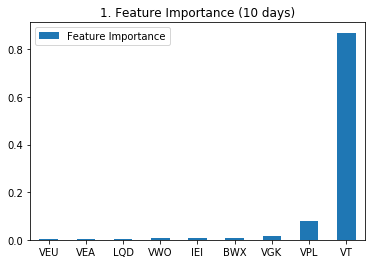

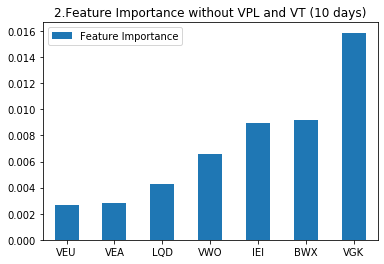

In [5]:
##Bar Plot##  
if target_as_feature:
    index = ['VTI','BWX', 'IEI','LQD','VEA','VEU', 'VGK','VPL','VT','VWO']
else:
    index = ['BWX', 'IEI','LQD','VEA','VEU', 'VGK','VPL','VT','VWO']
result=pd.DataFrame(FIP_by_index, index= index,columns= ['Feature Importance'])    

pic=result.sort_values(by=['Feature Importance'])
pic.plot.bar(rot=0, title='1. Feature Importance (%s days)'% history_steps)

pic2=pic.loc[['BWX', 'IEI','LQD','VEA','VEU', 'VGK','VWO'],:].sort_values(by=
            ['Feature Importance'])
pic2.plot.bar(rot=0, title='2.Feature Importance without VPL and VT (%s days)'% history_steps)

